## EE4483 Project: Dogs vs Cats Classification

Import necessary libraries here

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torchvision
from torchvision import models
import torch.nn as nn # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torchvision.datasets as datasets # Has standard datasets we can import in a nice way
import torchvision.transforms as transforms # Transformations we can perform on our dataset
import torch.nn.functional as F # All functions that don't have any parameters
from torch.utils.data import DataLoader, Dataset # Gives easier dataset managment and creates mini batches
from torchvision.datasets import ImageFolder
import torch.optim as optim # For all Optimization algorithms, SGD, Adam, etc.
from torch.optim import lr_scheduler
from PIL import Image
from tqdm import tqdm
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

Use gpu or cpu

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# print(torch.cuda.is_available())

Load dataset and Print amount of images

In [3]:
# from sklearn.model_selection import train_test_split
train_dataset = ImageFolder("../datasets/train")
valid_dataset = ImageFolder("../datasets/val")
# print(train_dataset.targets)
# 0 -> cat , 1 -> dog
# train_data, test_data, train_label, test_label = train_test_split(dataset.imgs, dataset.targets, test_size=0.2, random_state=42)
# ImageLoader Class
train_data, train_label = train_dataset.imgs, train_dataset.targets
test_data, test_label = valid_dataset.imgs, valid_dataset.targets

train_size = len(train_data)
valid_size = len(test_data)

print(f"[INFO]: Number of training images: {train_size}")
print(f"[INFO]: Number of validation images: {valid_size}")
print(f"[INFO]: Class names: {train_dataset.classes}\n")


[INFO]: Number of training images: 20000
[INFO]: Number of validation images: 5000
[INFO]: Class names: ['cat', 'dog']



Define augmentation for train and val images

In [4]:
train_transform = transforms.Compose([
                    transforms.Resize((224, 224)), 
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomRotation(15),
                    transforms.ToTensor(), 
                    transforms.Normalize([0.5]*3, [0.5]*3)
]) # train transform

test_transform = transforms.Compose([
                    transforms.Resize((224, 224)), 
                    transforms.ToTensor(), 
                    transforms.Normalize([0.5]*3, [0.5]*3)
]) # test transform

Load dataset into dataloader

In [5]:
class ImageLoader(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = self.checkChannel(dataset) # some images are CMYK, Grayscale, check only RGB 
        self.transform = transform
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, item):
        image = Image.open(self.dataset[item][0])
        classCategory = self.dataset[item][1]
        if self.transform:
            image = self.transform(image)
        return image, classCategory
        
    
    def checkChannel(self, dataset):
        datasetRGB = []
        for index in range(len(dataset)):
            if (Image.open(dataset[index][0]).getbands() == ("R", "G", "B")): # Check Channels
                datasetRGB.append(dataset[index])
        return datasetRGB

In [6]:
train_dataset = ImageLoader(train_data, train_transform)
valid_dataset = ImageLoader(test_data, test_transform)

train_loader = DataLoader(train_dataset, 
                        batch_size=64, 
                        shuffle=True)
test_loader = DataLoader(valid_dataset, 
                        batch_size=64,
                        shuffle=True)

Visualize random images in `train_loader`

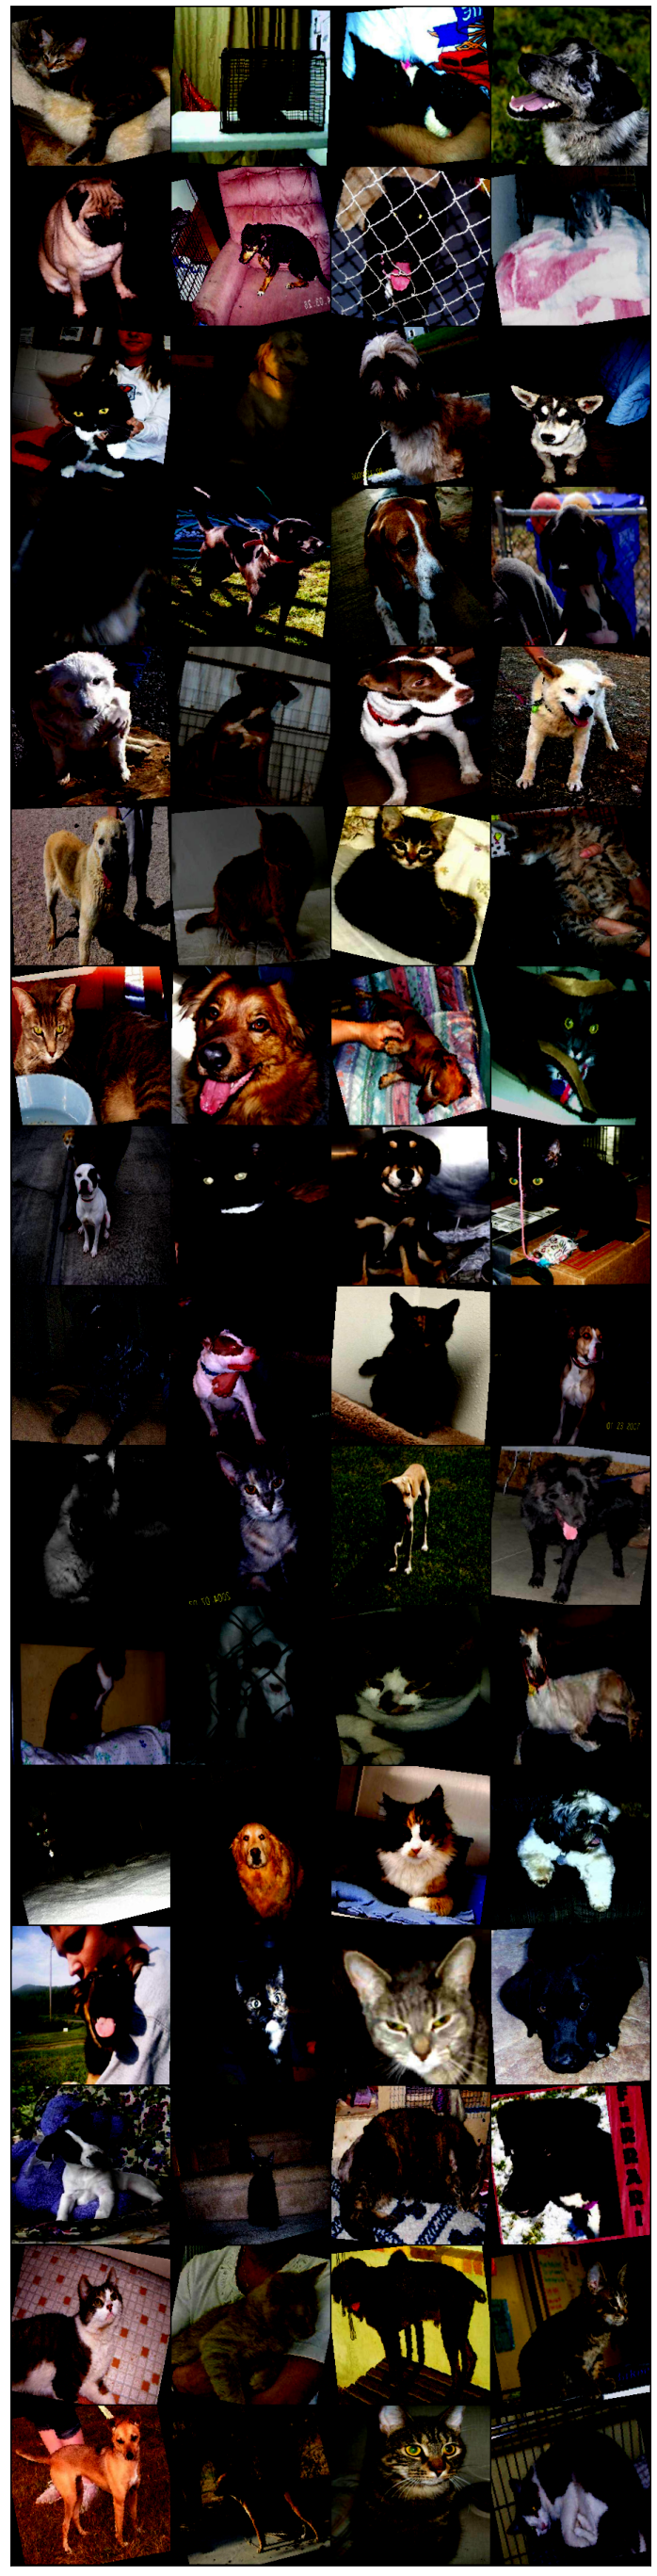

In [7]:
for images, labels in train_loader:
    # print(images)
    fig, ax = plt.subplots(figsize = (50, 50))
    ax.set_xticks([])
    ax.set_yticks([])
    images = np.clip(images, 0 , 1)
    ax.imshow(make_grid(images, 4).permute(1,2,0))
    break

Load `Resnet-18` and pass to GPU

In [8]:
# load pretrain model and modify...
model = models.resnet18(pretrained=True)

# If you want to do finetuning then set requires_grad = False
# Remove these two lines if you want to train entire model,
# and only want to load the pretrain weights.

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)
    
model.to(device)

c:\Users\65913\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\65913\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Define `Train` and `Test` functions

In [9]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Learning Rate Scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.5)
save_path = '../outputs/trained_model'
learning_rate = []
training_loss = []
validation_loss = []
training_accuracy = []
valid_accuracy = []

# Train and test

def train(current_epoch, num_epoch, model):
    current_loss = 0.0
    current_corrects = 0
    losses = []
    model.train()

    loop = tqdm(enumerate(train_loader), total=len(train_loader)) # create a progress bar
    for batch_idx, (data, targets) in loop:
        data = data.to(device=device)
        targets = targets.to(device=device)
        scores = model(data)
        
        loss = criterion(scores, targets)
        optimizer.zero_grad()
        losses.append(loss)
        
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(scores, 1)
        current_loss += loss.item() * data.size(0)
        current_corrects += (preds == targets).sum().item()
        loop.set_description(f"Epoch {current_epoch+1}/{num_epoch} process: {int((batch_idx / len(train_loader)) * 100)}")
        loop.set_postfix(loss=loss.data.item())
    
    # update lr here if using stepLR
    scheduler.step()

    epoch_accuracy = int(current_corrects / len(train_loader.dataset) * 100)
    epoch_losses =  current_loss / len(train_loader.dataset)
    training_accuracy.append(epoch_accuracy)
    training_loss.append(epoch_losses)
    # save learning rate
    learning_rate.append(scheduler.optimizer.param_groups[0]['lr'])
    
    # save model
    torch.save({ 
                'model_state_dict': model.state_dict(), 
                'optimizer_state_dict': optimizer.state_dict(), 
                }, os.path.join(save_path,'checpoint_epoch_'+str(current_epoch)+'.pt'))


        
# model.eval() is a kind of switch for some specific layers/parts of the model that behave differently,
# during training and inference (evaluating) time. For example, Dropouts Layers, BatchNorm Layers etc. 
# You need to turn off them during model evaluation, and .eval() will do it for you. In addition, 
# the common practice for evaluating/validation is using torch.no_grad() in pair with model.eval() 
# to turn off gradients computation:
        
def test():
    model.eval()
    test_loss = 0
    current_loss = 0
    correct = 0
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            output = model(x)
            _, predictions = torch.max(output, 1)
            correct += (predictions == y).sum().item()
            test_loss = criterion(output, y)
            current_loss += test_loss.item() * x.size(0)
            
    current_loss /= len(test_loader.dataset)
    validation_loss.append(current_loss)
    valid_accuracy.append(correct / len(test_loader.dataset) * 100)

    print("Average Loss: ", current_loss, "  Accuracy: ", correct, " / ",
    len(test_loader.dataset), "  ", int(correct / len(test_loader.dataset) * 100), "%")


def train_model(num_epoch, model):
    for epoch in range(0, num_epoch):
        train(epoch, num_epoch, model)
        test()


In [10]:
# train(5, model) # train
# test() # test
total_epoch = 10
train_model(total_epoch, model)

# print(learning_rate)
# print(training_loss)
# print(training_accuracy)
# print(validation_loss)
# print(valid_accuracy)

Epoch 1/10 process: 99: 100%|██████████| 313/313 [01:27<00:00,  3.58it/s, loss=0.652] 


Average Loss:  0.09152254587225615   Accuracy:  4837  /  5000    96 %


Epoch 2/10 process: 99: 100%|██████████| 313/313 [01:23<00:00,  3.74it/s, loss=0.0377] 


Average Loss:  0.06395846501588821   Accuracy:  4880  /  5000    97 %


Epoch 3/10 process: 99: 100%|██████████| 313/313 [01:22<00:00,  3.77it/s, loss=0.156]  


Average Loss:  0.06664917126498185   Accuracy:  4881  /  5000    97 %


Epoch 4/10 process: 99: 100%|██████████| 313/313 [01:23<00:00,  3.76it/s, loss=0.0119]  


Average Loss:  0.07813173665571958   Accuracy:  4881  /  5000    97 %


Epoch 5/10 process: 99: 100%|██████████| 313/313 [01:23<00:00,  3.75it/s, loss=0.0698] 


Average Loss:  0.06871313779875633   Accuracy:  4897  /  5000    97 %


Epoch 6/10 process: 99: 100%|██████████| 313/313 [01:22<00:00,  3.80it/s, loss=0.00369] 


Average Loss:  0.06580547245933557   Accuracy:  4878  /  5000    97 %


Epoch 7/10 process: 99: 100%|██████████| 313/313 [01:23<00:00,  3.77it/s, loss=0.145]  


Average Loss:  0.07734522621787619   Accuracy:  4855  /  5000    97 %


Epoch 8/10 process: 99: 100%|██████████| 313/313 [01:22<00:00,  3.79it/s, loss=0.0522]  


Average Loss:  0.0939767767213285   Accuracy:  4846  /  5000    96 %


Epoch 9/10 process: 99: 100%|██████████| 313/313 [01:23<00:00,  3.73it/s, loss=0.0075] 


Average Loss:  0.06085054667312652   Accuracy:  4890  /  5000    97 %


Epoch 10/10 process: 99: 100%|██████████| 313/313 [01:23<00:00,  3.73it/s, loss=0.00839]


Average Loss:  0.06285803109770641   Accuracy:  4892  /  5000    97 %


Visualize `Accuracy` and `Losses`

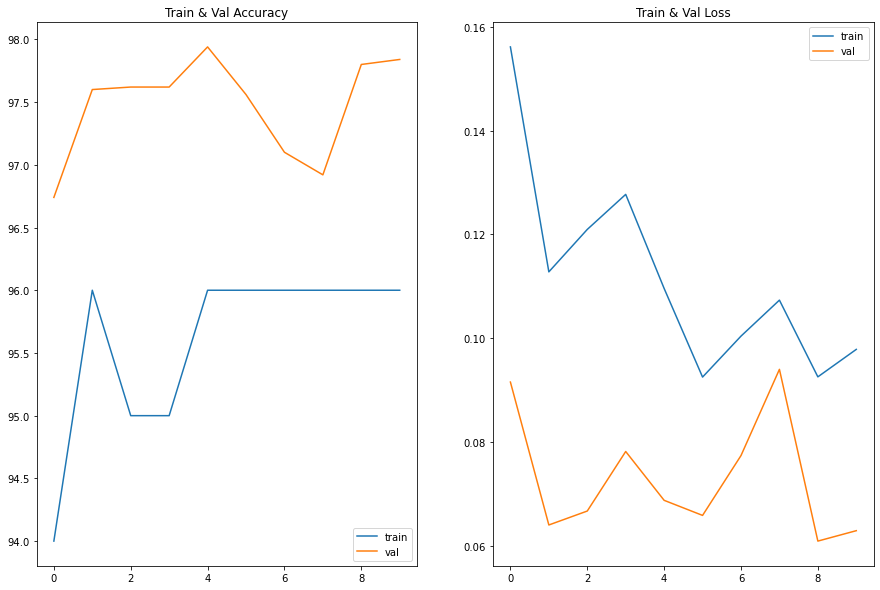

In [11]:
epc = []
for x in range(total_epoch):
    epc.append(x)

fig, axs = plt.subplots(1, 2, figsize=(15,10))
axs[0].set_title('Train & Val Accuracy')
axs[0].plot(epc, training_accuracy,label='train')
axs[0].plot(epc, valid_accuracy,label='val')
axs[0].legend(loc='lower right')
axs[1].set_title('Train & Val Loss')
axs[1].plot(epc, training_loss,label='train')
axs[1].plot(epc, validation_loss,label='val')
axs[1].legend(loc='upper right')

Load the trained model

In [19]:
print("----> Loading checkpoint")
checkpoint = torch.load("../outputs/trained_model/checpoint_epoch_9.pt") # Try to load last checkpoint
model.load_state_dict(checkpoint["model_state_dict"]) 
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

----> Loading checkpoint


Load test images into `DataLoader` and input to model

In [22]:
TEST_DIR = '../datasets/test'
id = []
test_imgs = os.listdir(TEST_DIR)
test_imgs = sorted(test_imgs, key=lambda x: int(x.split(".")[0]))
for image in test_imgs:
    id.append(image.split(".")[0])
# print(id)

# Custom function to load test images
class CatDogDataset(Dataset):
    
    def __init__(self, imgs, transform = None):
        
        super().__init__()
        self.imgs = imgs
        self.transform = transform
        
    def __getitem__(self, idx):
        
        image_name = self.imgs[idx]
        img = Image.open(os.path.join(TEST_DIR, image_name))
        
        ### Apply Transforms on image
        img = self.transform(img)

        return img
            
        
    def __len__(self):
        return len(self.imgs)

test_transform = transforms.Compose([
                         transforms.Resize((224, 224)), 
                         transforms.ToTensor(), 
                         transforms.Normalize([0.5]*3, [0.5]*3)
                     ])

# Check the test set
dataset = CatDogDataset(test_imgs, 
                     transform=test_transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle = False)

predictions = []
# for j, (data, labels) in enumerate(dataloader):
with torch.no_grad():
    model.eval()
    for data in dataloader:
        data = data.to(device)
        output = model(data)
        _, predicted = torch.max(output, 1)
        predictions.append(predicted[0].item()) # store all predictions in array
        # print(f"predicted ----> {predicted[0]}")

# print(predictions)
# 0 -> Cat
# 1 -> Dog

In [25]:
# Convert class idx to string
string_label = []
for label in predictions:
    if label == 0:
        string_label.append('cat')
    elif label == 1:
        string_label.append("dog")
    else:
        string_label.append("null")

Create submission csv

In [27]:
d = {'id':id, 'label':string_label}
output_df = pd.DataFrame(data=d)
output_df.to_csv('../outputs/submission1.csv',index=False)